In [2]:
import numpy as np
import matplotlib.pyplot as plt
import graspy
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.neighbors import KNeighborsClassifier as KNN
from scipy.stats import multivariate_normal as mvn, beta, norm
from tqdm import tqdm_notebook as tqdm
%matplotlib inline

In [3]:
def MVN_sampler(counts, params, seed=None):
    if seed is None:
        seed = np.random.randint(10**6)
    np.random.seed(seed)
    
    n = np.sum(counts)
    K = len(params)
    p = len(params[0][0])
    
    samples = np.zeros((n,d))
    c = 0
    class_idx = 0
    
    for i in range(K):
        idx = np.arange(sum(counts[:i]),np.sum(counts[:i+1]))
        samples[idx] = np.random.multivariate_normal(params[0][i], params[1][i], counts[i])
        
    return samples

def beta_sampler(counts, params, seed=None):
    if seed is None:
        seed = np.random.randint(10**6)
    np.random.seed(seed)
    
    n = np.sum(counts)
    d = len(params[0])
    K = len(counts)
        
    samples = np.zeros((n, d))
    for k in range(K):
        for i in range(d):
            samples[np.sum(counts[:k]): np.sum(counts[:k+1]), i] = np.random.beta(params[k][0][i],
                                                                                  params[k][1][i], 
                                                                                  counts[k])
    return samples

def conditional_MVN_sampler(Z, rho, counts, params, seed=None):
    # could be written in MVN_sampler
    # rho is not 'correlation' but just a scale for Z_{ij}. however, rho = 0 => correlation = 0
    if seed is None:
        seed = np.random.randint(10**6)
        
    np.random.seed(seed)
    K = len(counts)
    
    X = np.zeros(Z.shape)
    p = len(params[0][0])
    
    for i in range(K):
        for c in range(counts[i]):
            temp_Z = np.prod(Z[np.sum(counts[:i]) + c])
            X[np.sum(counts[:i]) + c] = rho*temp_Z*np.random.multivariate_normal(params[0][i], 
                                                                      params[1][i])
    
    return X

def estimate_normal_parameters(samples):
    return np.mean(samples, axis = 0), np.cov(samples, rowvar=False)

def classify(X, Z, normal_params, fitted_model):
    n, p = X.shape
    m, d = Z.shape
    
    K = len(normal_params)
    
    if n != m:
        raise ValueError('different number of samples for X, Z')
    
    if p == 1:
        norm_pdf = norm.pdf
    else:
        norm_pdf = mvn.pdf
        
    posteriors = fitted_model.predict_proba(Z)
#     print(posteriors)
    
    predictions=-1*np.zeros(n)
    for i in range(n):
        temp_pdfs = np.array([norm_pdf(X[i,:], normal_params[j][0], normal_params[j][1]) for j in range(K)])
#         print(temp_pdfs)
        posterior_pdf_prod = temp_pdfs * posteriors[i]
#         print(posterior_pdf_prod)
        predictions[i] = int(np.argmax(posterior_pdf_prod))
        
    return predictions

def error_rate(truth, predictions, seed_idx = None, metric = 'accuracy'):
    if metric == 'accuracy':
        if seed_idx is None:
            return 1 - np.sum(predictions == truth)/len(truth)
        
def estimate_bayes(n, pi, normal_params, beta_params, seed=None):
    if seed is None:
        seed = np.random.randint(10**6)
        
    p = len(normal_params[0][0])
    if p == 1:
        norm_pdf = norm.pdf
    else:
        norm_pdf = mvn.pdf
        
    K = len(normal_params)
    
    d = len(beta_params[0])
        
    counts = np.round(np.array(n*(pi*np.ones(K))).astype(int))
    labels = np.concatenate((np.zeros(counts[0]), np.ones(counts[1])))
    X = MVN_sampler(counts, normal_params)
    Z = beta_sampler(counts, beta_params)
    
    predictions = -1*np.ones(n)
    for i in range(n):
        normal_pdfs = [pi[k]*norm_pdf(X[i], normal_params[0][k], normal_params[1][k]) for k in range(K)]
        beta_pdfs = np.ones(d)
        for j in range(d):
            for k in range(K):
                beta.pdf(Z[i,j], beta_params[k][0][j], beta_params[k][1][j])
            beta_pdfs *= np.array([beta.pdf(Z[i,j], beta_params[k][0][j], beta_params[k][1][j]) for k in range(K)])
        predictions[i] = np.argmax(normal_pdfs * beta_pdfs)
        
    return error_rate(labels, predictions)

In [4]:
pi0 = 0.5
seed_ratio = 0.1
p = 2
mean = 0.5*np.ones(p)
means = np.array([mean, -1*mean])
covariances = np.zeros((2, p, p))
covariances[0] = 1*np.eye(p)
covariances[1] = 1*np.eye(p)
normal_params = [means, covariances]

d = 2

a1 = 3*np.ones(d)
a2 = 5*np.ones(d)
beta1 = [a1, a2]
beta2 = [a2, a1]
beta_params = [beta1, beta2]

rho=1

In [5]:
np.random.seed(1)

M = 100
n = [100, 200, 500, 1000, 2000, 5000]

HHRF_preds = [[] for _ in n]
HHKNN_preds = [[] for _ in n]
RF_preds = [[] for _ in n]
KNN_preds = [[] for _ in n]

for i in tqdm(range(len(n))):
    for j in range(M):
        #- Multinomial trial
        counts = np.random.multinomial(n[i], [pi0, 1 - pi0])
        K = len(counts)
        labels = np.concatenate((np.zeros(counts[0]), np.ones(counts[1])))

        #- number of seeds = n/10
        n_seeds = np.round(0.1*counts).astype(int)
        class_train_idx = [range(np.sum(counts[:k]), np.sum(counts[:k]) + n_seeds[k]) for k in range(K)]
        train_idx = np.concatenate((class_train_idx)).astype(int)

        test_idx = [k for k in range(n[i]) if k not in train_idx]

        m = np.sum(n_seeds)

        #- estimate class probabilities
        
        beta_samples = beta_sampler(counts, beta_params)
        Z = beta_samples

        #- Sample from multivariate normals / uniform distributions
        normal_samples = conditional_MVN_sampler(Z, rho=rho, counts=counts, params=normal_params)
        X = normal_samples

#         beta_samples = beta_sampler(counts, beta_params)
#         Z = beta_samples

        XZ = np.concatenate((X, Z), axis = 1)

        #- Store mvn samples corresponding to seeds

        seeds_norm = X[train_idx]

        #- Estimate normal parameters using seeds
        mu1, cov1 = estimate_normal_parameters(X[class_train_idx[0]])
        params1 = [mu1, cov1]

        mu2, cov2 = estimate_normal_parameters(X[class_train_idx[1]])
        params2 = [mu2, cov2]

        #- Convenient way to store
        params=[params1, params2]

        #- Store uniform samples corresponding to seeds
        seeds_beta = Z[train_idx]

        #- Using conditional indendence assumption (RF, KNN used for posterior estimates)
        rf1 = RF(n_estimators=100, max_depth=np.log(seeds_beta.shape[0]))
        rf1.fit(seeds_beta, labels[train_idx])
        
        temp_pred = classify(X[test_idx], Z[test_idx], params, rf1)
        temp_error = 1 - np.sum(temp_pred == labels[test_idx])/len(test_idx)
        HHRF_preds[i].append(temp_error)
        
        knn1 = KNN(n_neighbors=int(np.round(np.log(m))))
        knn1.fit(seeds_beta, labels[train_idx])

        temp_pred = classify(X[test_idx], Z[test_idx], params, knn1)
        temp_error = 1 - np.sum(temp_pred == labels[test_idx])/len(test_idx)
        HHKNN_preds[i].append(temp_error)

        #- Not using conditional independence assumption (RF, KNN used for classification)
        XZseeds = np.concatenate((seeds_norm, seeds_beta), axis=1)
        
        rf2 = RF(n_estimators=100, max_depth=np.log(XZseeds.shape[0]))
        rf2.fit(XZseeds, labels[train_idx])
        temp_pred = rf2.predict(XZ[test_idx])
        temp_error = 1 - np.sum(temp_pred == labels[test_idx])/len(test_idx)
        RF_preds[i].append(temp_error)
        
        knn2 = KNN(n_neighbors=int(np.round(np.log(m))))
        knn2.fit(XZseeds, labels[train_idx])

        temp_pred = knn2.predict(XZ[test_idx])
        temp_error = 1 - np.sum(temp_pred == labels[test_idx])/len(test_idx)
        KNN_preds[i].append(temp_error)

In [6]:
HHRF_means = np.array([np.mean(hh) for hh in HHRF_preds])
RF_means = np.array([np.mean(rf) for rf in RF_preds])
HHKNN_means = np.array([np.mean(hh) for hh in HHKNN_preds])
KNN_means = np.array([np.mean(knn) for knn in KNN_preds])

HHRF_stderrs = np.array([np.std(hh, ddof=1) for hh in HHRF_preds])/np.sqrt(M)
RF_stderrs = np.array([np.std(rf, ddof=1) for rf in RF_preds])/np.sqrt(M)
HHKNN_stderrs = np.array([np.std(hh, ddof=1) for hh in HHKNN_preds])/np.sqrt(M)
KNN_stderrs = np.array([np.std(knn, ddof=1) for knn in KNN_preds])/np.sqrt(M)

# bayes = estimate_bayes(10000, np.array([0.5, 0.5]), normal_params, beta_params)
# Bayes way more complicated in non-independent setting

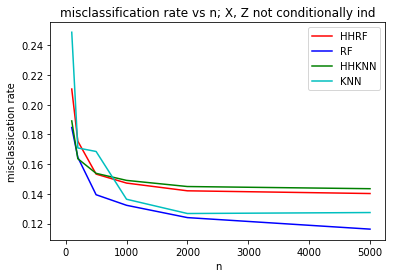

In [7]:
fig, ax = plt.subplots(1,1)

ax.plot(n, HHRF_means, label = 'HHRF', c = 'r')
ax.plot(n, RF_means, label = 'RF', c = 'b')
ax.plot(n, HHKNN_means, label = 'HHKNN', c = 'g')
ax.plot(n, KNN_means, label = 'KNN', c= 'c')

# ax.axhline(y=bayes, label = 'Bayes')
ax.set_title('misclassification rate vs n; X, Z not conditionally ind')
ax.set_ylabel('misclassication rate')
ax.set_xlabel('n')
for i in range(len(HHRF_means)):
    ax.fill_between(HHRF_means, 
                    HHRF_means[i] + HHRF_stderrs[i], 
                    HHRF_means[i] - HHRF_stderrs[i], 
                    where=HHRF_means[i] + 1.96*HHRF_stderrs[i] >= HHRF_means[i] - 1.96*HHRF_stderrs[i], 
                    facecolor='b', 
                    alpha=0.15,
                    interpolate=True)
    ax.fill_between(RF_means, 
                    RF_means[i] + RF_stderrs[i], 
                    RF_means[i] - RF_stderrs[i], 
                    where=RF_means[i] + 1.96*RF_stderrs[i] >= RF_means[i] - 1.96*RF_stderrs[i], 
                    facecolor='b', 
                    alpha=0.15,
                    interpolate=True)
ax.legend()
plt.savefig('scale_not_cond_ind_actual_normal.png')